In [1]:
import os
import joblib
import pickle
import yaml

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

from prediction_utils.pytorch_utils.metrics import StandardEvaluator
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter


from scipy.stats import pearsonr

pd.options.display.max_rows = 100

In [2]:
artifacts_fpath = '/local-scratch/nigam/projects/lguo/temp_ds_shift_robustness/experiments/dg/artifacts'
baseline_artifacts_fpath = '/local-scratch/nigam/projects/lguo/temp_ds_shift_robustness/experiments/baseline/artifacts'

In [3]:
y_axis = {
    'auc':{
        'lim':[-0.3, 0.1],
        'label':'AUROC'
    },
    'auprc':{
        'lim':[-0.4, 0.1],
        'label':'AUPRC'
    },
    'ace_abs_logistic_logit':{
        'lim':[-0.01, 0.1],
        'label':'Calibration'
    },
    'loss_bce':{
        'lim':[0, 0.4],
        'label':'BCE Loss'
    }
}
tasks = {
    'hospital_mortality':'Mortality',
    'LOS_7':'Long LOS',
    'readmission_30':'Readmission',
    'icu_admission':'ICU Admission'
}
algos = {
    'irm':'IRM',
    'dro':'GroupDRO',
    'coral':'CORAL', 
    'adversarial':'AL',
}
metrics = {
    'auc':'AUROC',
    'auprc':'AUPRC',
    'ace_abs_logistic_logit':'Calibration'
}
train_years = {
    '2009_2010_2011_2012':'09-12',
    '2010_2011_2012_2013':'10-13',
    '2011_2012_2013_2014':'11-14',
    '2012_2013_2014_2015':'12-15',
    '2013_2014_2015_2016':'13-16',
    '2014_2015_2016_2017':'14-17',
    '2015_2016_2017_2018':'15-18',
    '2009_2010_2011_2012_2013':'09-13',
    '2009_2010_2011_2012_2013_2014':'09-14',
    '2009_2010_2011_2012_2013_2014_2015':'09-15',
    '2009_2010_2011_2012_2013_2014_2015_2016':'09-16',
    '2009_2010_2011_2012_2013_2014_2015_2016_2017':'09-17',
    '2009_2010_2011_2012_2013_2014_2015_2016_2017_2018':'09-18',
}

#### 09-12 Sweep

OOD evaluation of all hyperparameter values trained on 09-12


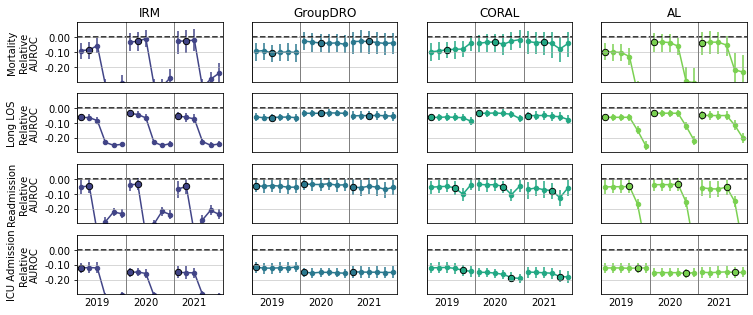

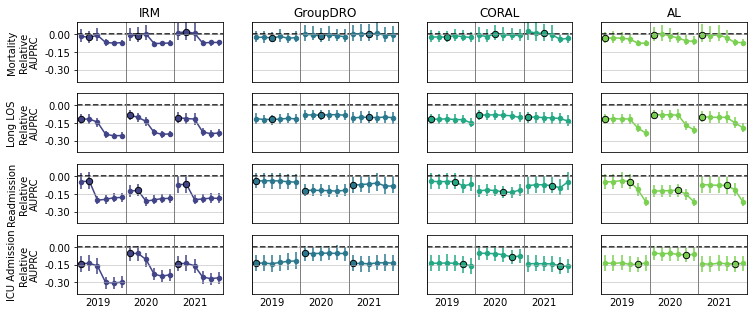

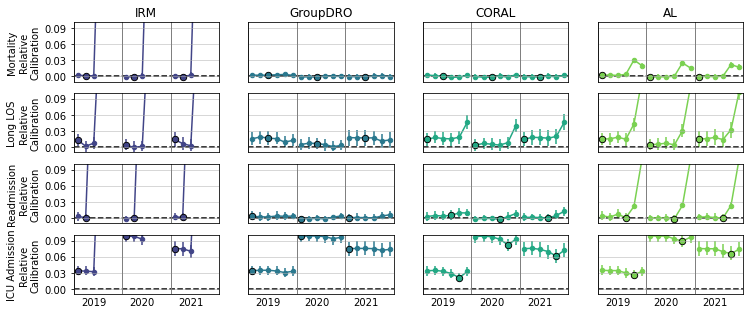

OOD evaluation of all hyperparameter values trained on 10-13


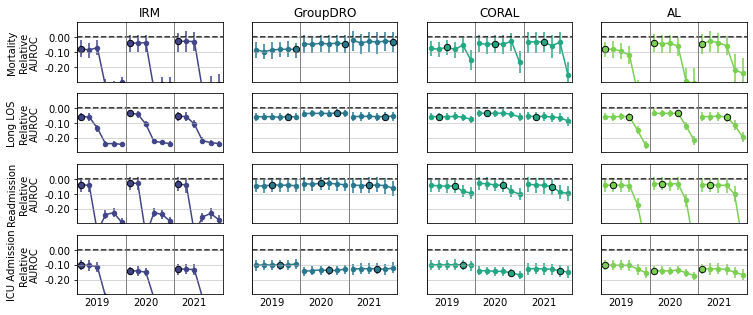

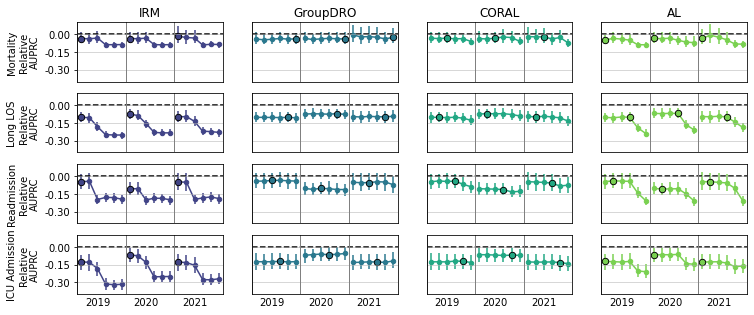

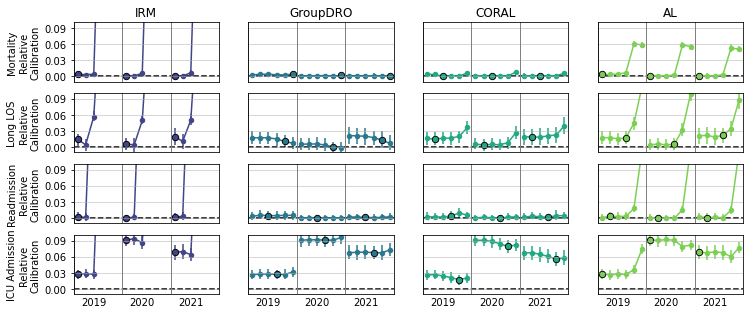

OOD evaluation of all hyperparameter values trained on 11-14


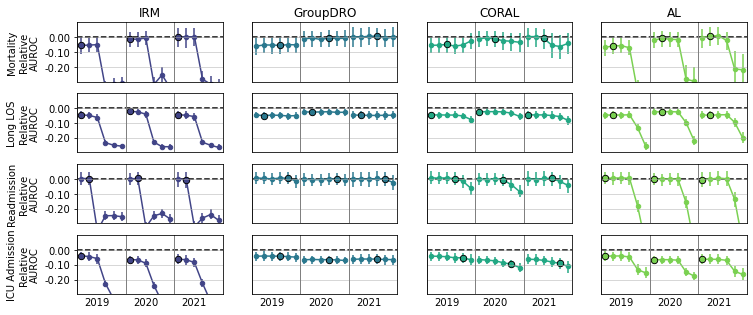

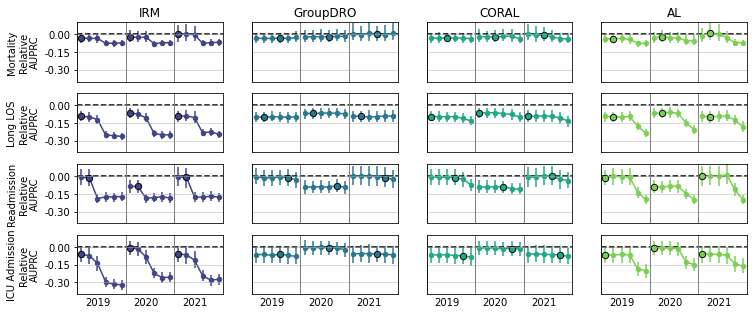

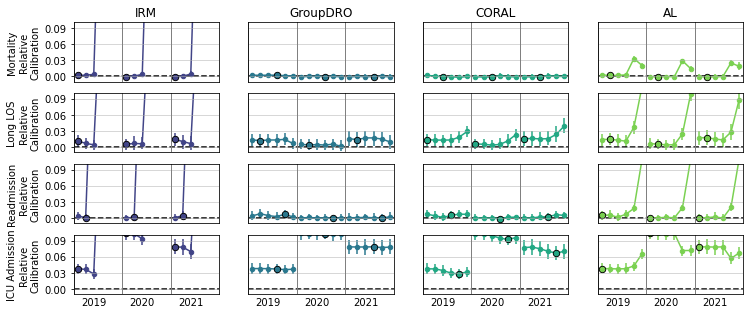

OOD evaluation of all hyperparameter values trained on 12-15


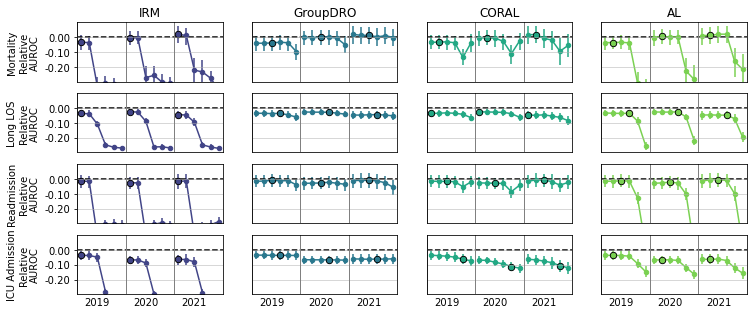

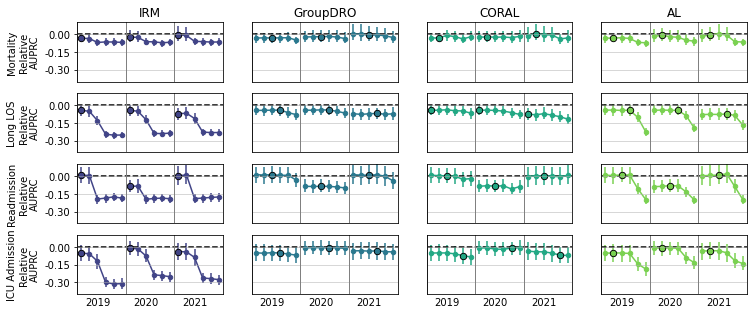

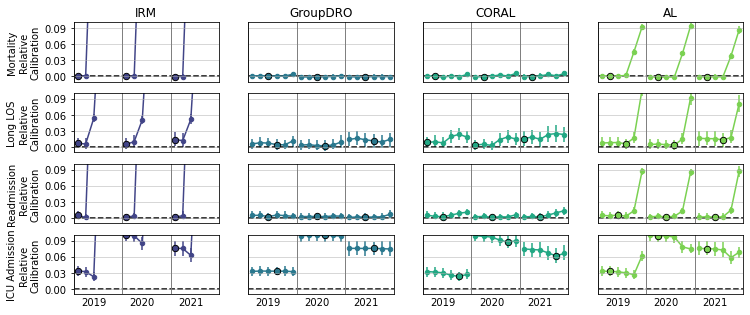

OOD evaluation of all hyperparameter values trained on 13-16


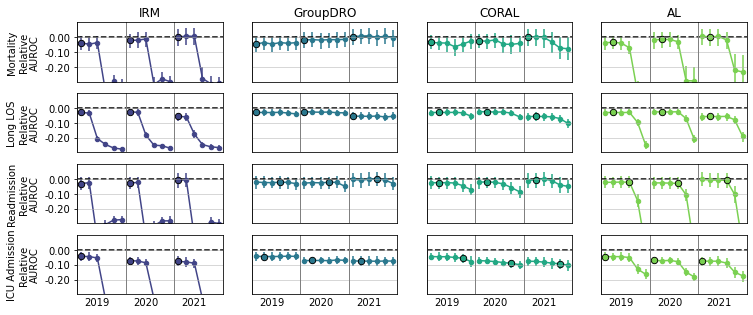

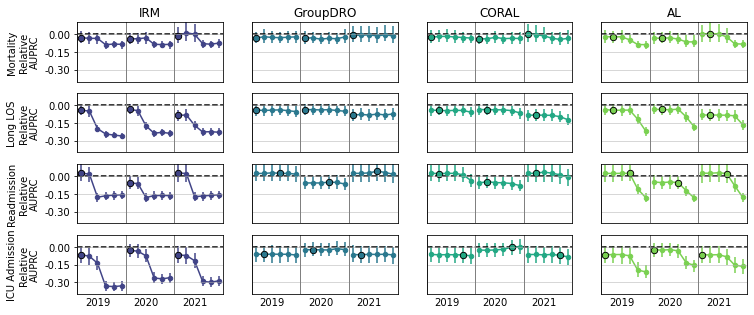

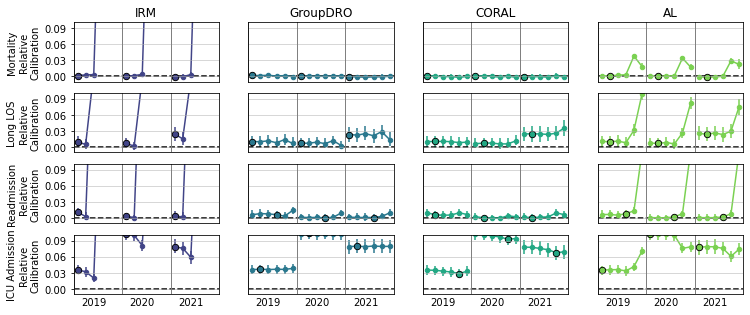

OOD evaluation of all hyperparameter values trained on 14-17


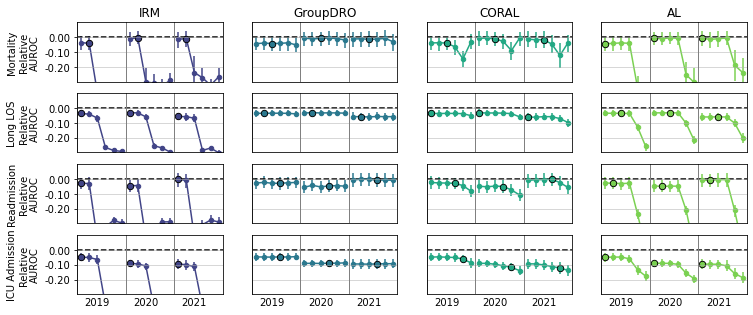

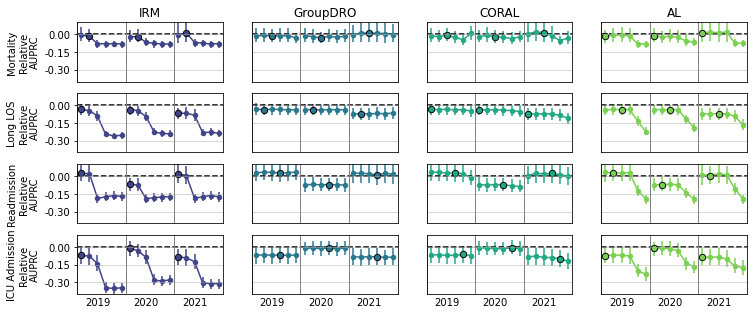

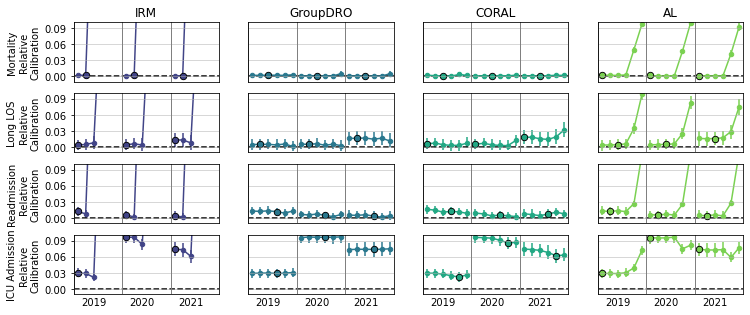

OOD evaluation of all hyperparameter values trained on 15-18


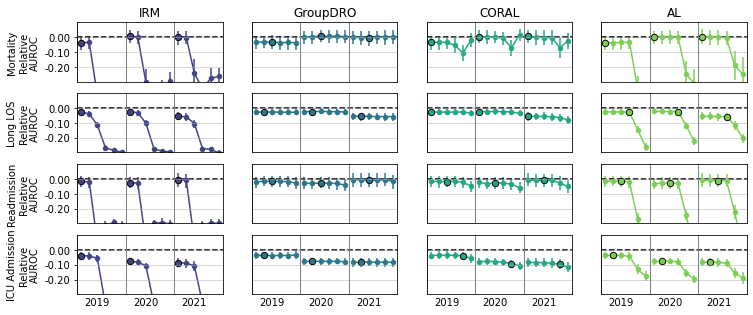

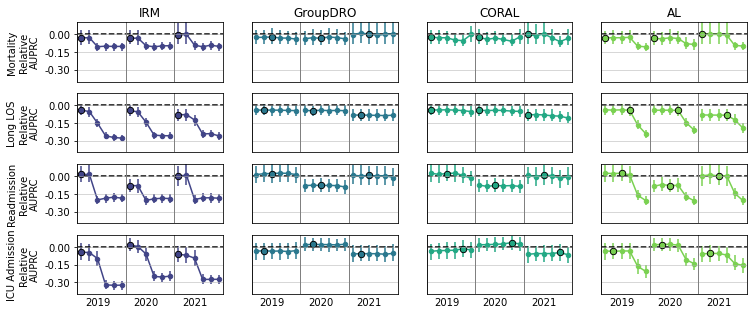

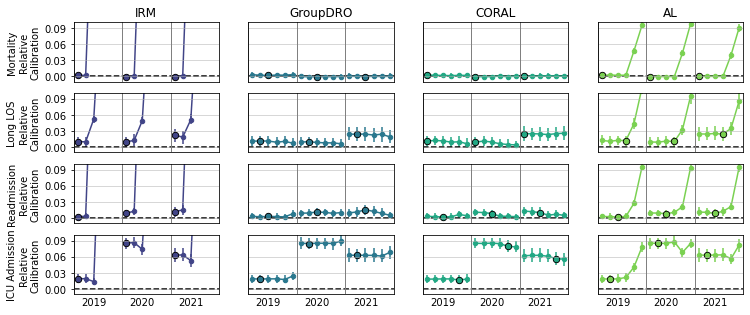

OOD evaluation of all hyperparameter values trained on 09-13


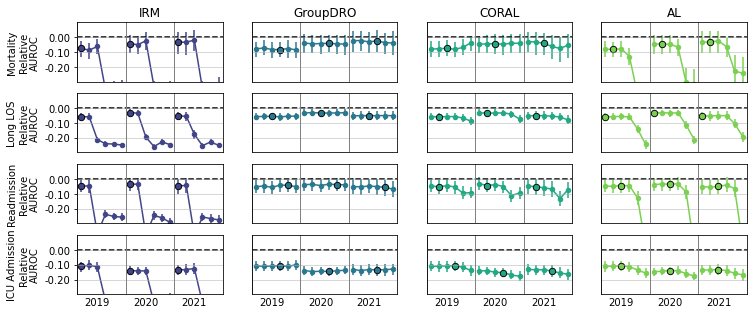

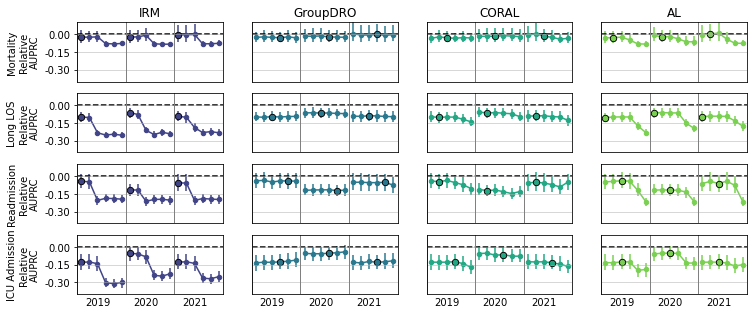

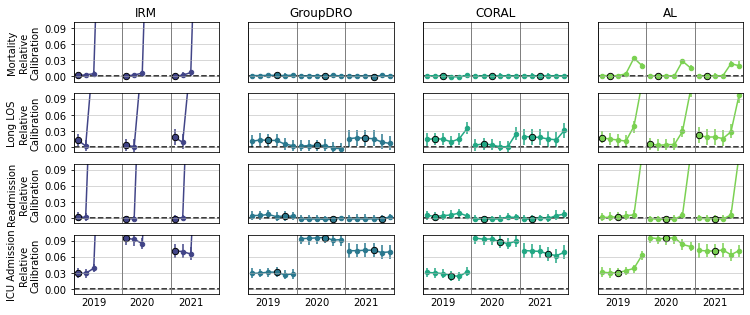

OOD evaluation of all hyperparameter values trained on 09-14


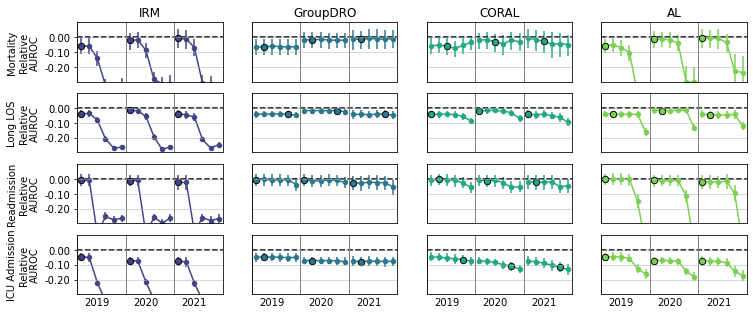

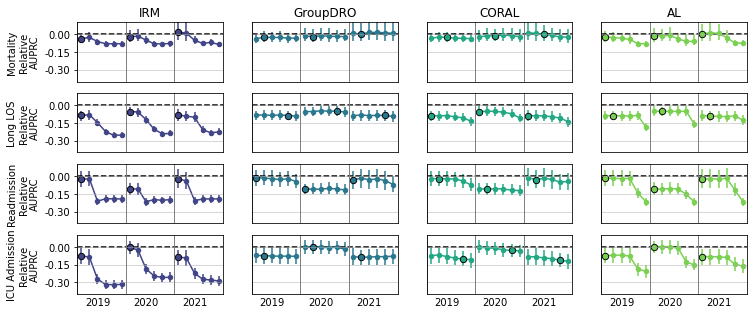

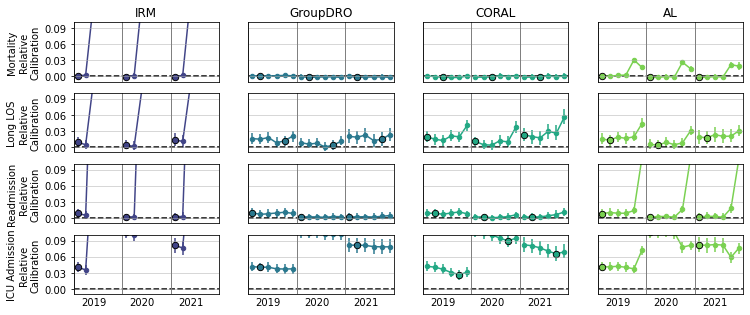

OOD evaluation of all hyperparameter values trained on 09-15


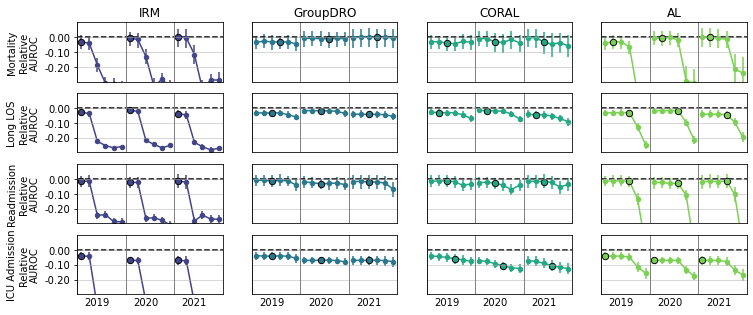

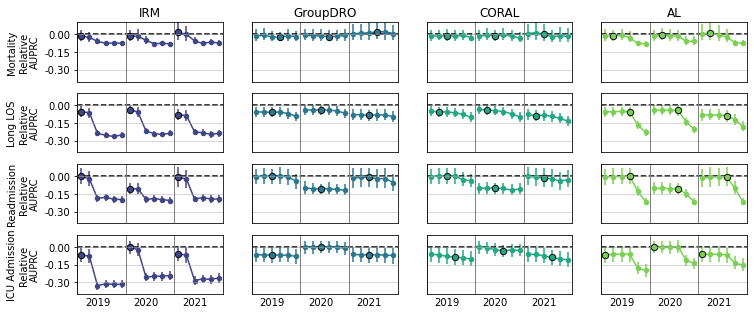

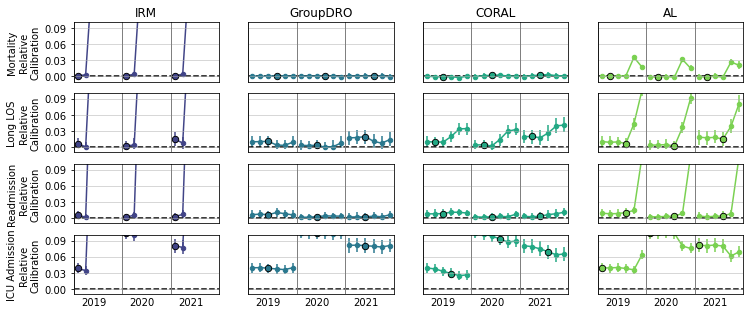

OOD evaluation of all hyperparameter values trained on 09-16


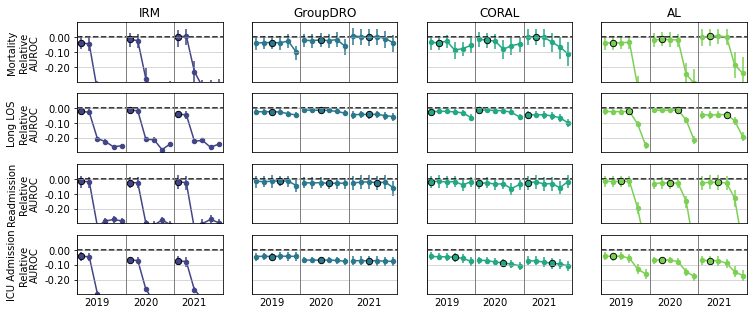

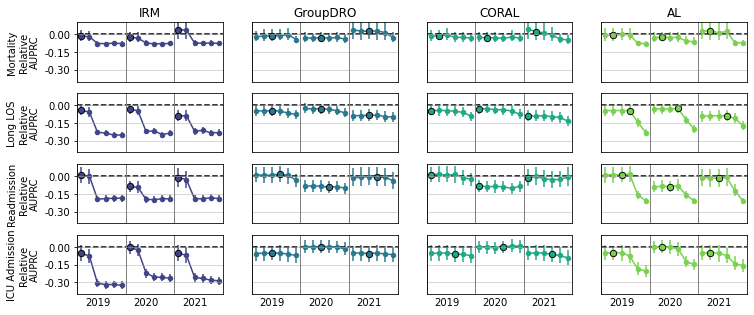

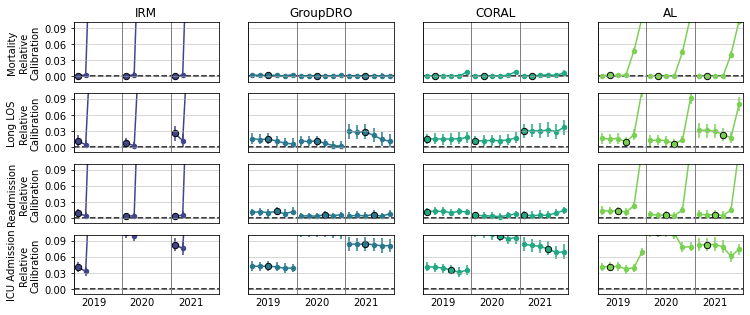

OOD evaluation of all hyperparameter values trained on 09-17


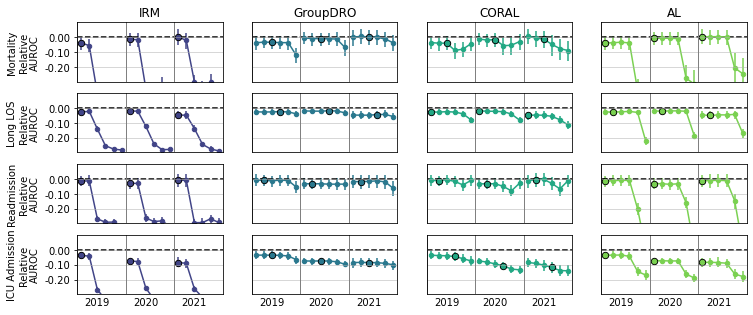

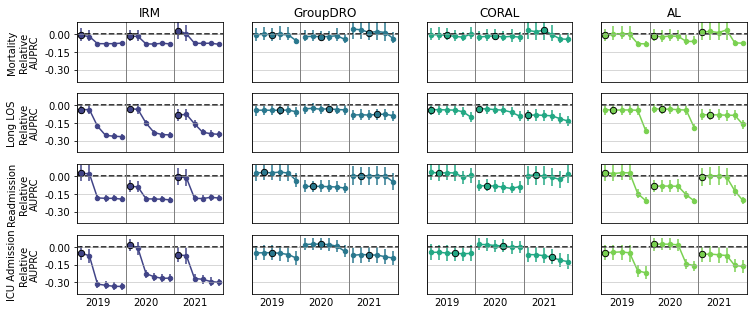

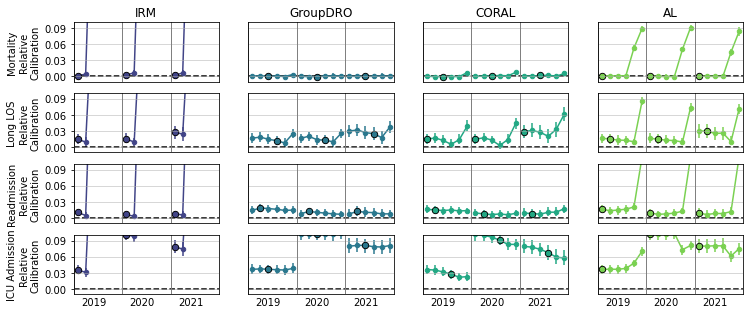

OOD evaluation of all hyperparameter values trained on 09-18


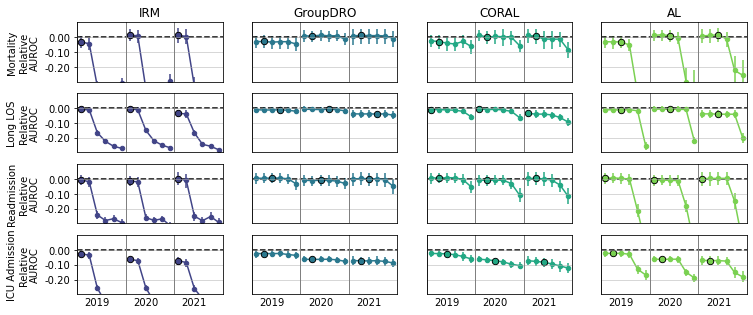

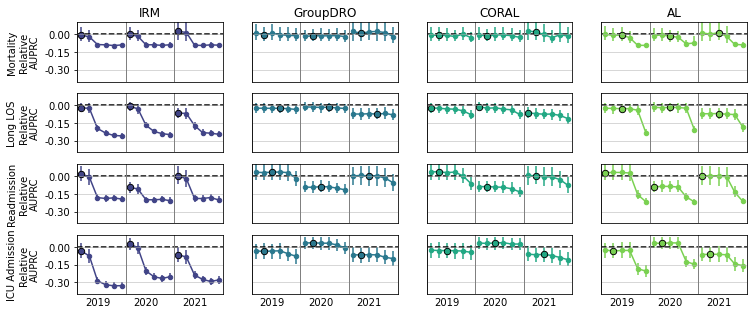

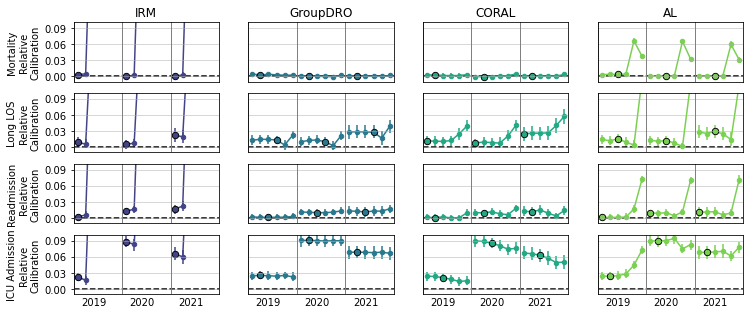

In [4]:
for year in train_years:
    print(f"OOD evaluation of all hyperparameter values trained on {train_years[year]}")
    
    ## Load Evals
    df = pd.DataFrame()
    df_hparams = pd.DataFrame()
    
    ## GATHER DATA
    for task in tasks:
        for algo in algos:

            # grab sweep results
            fpath = os.path.join(
                artifacts_fpath,
                task,
                f"eval/{algo}_{year}"
            )

            df = pd.concat((
                df,
                pd.concat((
                    pd.read_csv(
                       f"{fpath}/{x}" 
                    ).assign(
                        lambd=x.split("_")[-1].replace('.csv',''),
                        algo=algo,
                        task=task
                    ) 
                    for x in os.listdir(fpath)
                    if 'sweep' in x
                ))
            ))

            # grab best hparam value
            fpath = os.path.join(
                artifacts_fpath,
                task,
                f"models/{algo}_{year}"
            )

            best_model_name = [x for x in os.listdir(fpath) if "best_model" in x][0]

            hparams = yaml.load(
                open(f"{fpath}/{best_model_name}/hparams.yml"),
                Loader=yaml.FullLoader
            )

            df_hparams = pd.concat((
                df_hparams,
                pd.DataFrame({k:[v] for k,v in hparams.items()}).assign(
                    Task=task,
                    Train_Group=year,
                    Algorithm=algo,
                    Lambda=hparams['lr_lambda'] if algo=='dro' else hparams['lambda_group_regularization']
                )
            ))

    ## PLOT
    for metric in metrics:

        fig, axes = plt.subplots(nrows = len(tasks), ncols=len(algos),figsize=(12,5))

        for r,task in enumerate(tasks):
            for c,algo in enumerate(algos):

                df_eval = df.query(
                    "task==@task and metric==@metric and algo==@algo \
                    and test_group==['2019','2020','2021']"
                )

                # baseline (0)
                year_groups = df_eval['test_group'].unique() 

                axes[r][c].plot(
                    [0.5, len(year_groups)*len(df_eval['lambd'].unique())+0.5],
                    [0,0],
                    '--',
                    c = 'black',
                    zorder = 0
                )


                for g, year_group in enumerate(year_groups):

                    temp = df_eval.query("test_group==@year_group")

                    data = temp.query("CI_quantile_95=='mid'").reset_index(drop=True)

                    data['CI_upper'] = (
                        temp.query("CI_quantile_95=='upper'").reset_index()['delta'] - 
                        temp.query("CI_quantile_95=='mid'").reset_index()['delta']
                    ).abs()

                    data['CI_lower'] = (
                        temp.query("CI_quantile_95=='lower'").reset_index()['delta'] - 
                        temp.query("CI_quantile_95=='mid'").reset_index()['delta']
                    ).abs()

                    # sort by lambda
                    data['lambd']=data['lambd'].astype(float)
                    data = data.sort_values('lambd').reset_index(drop=True)

                    # get selected lambda
                    sel_lamb = df_hparams.query("Task==@task and Algorithm==@algo")['Lambda'].values[0]
                    sel_lamb_x = data.index[data['lambd']==sel_lamb].values[0] 
                    sel_lamb_y = data.query("lambd==@sel_lamb")['delta'].values[0]

                    # plot selected lambda
                    axes[r][c].scatter(
                        sel_lamb_x + g*data.shape[0] + 1,
                        sel_lamb_y,
                        s=40,
                        color='black',
                    )

                    # scatter
                    axes[r][c].scatter(
                        np.arange(g*data.shape[0]+1,(g+1)*data.shape[0]+1,1),
                        data['delta'].values,
                        s = 20,
                        color = sns.color_palette('viridis',n_colors=len(algos))[c],
                    )

                    # error bar
                    axes[r][c].errorbar(
                        np.arange(g*data.shape[0]+1,(g+1)*data.shape[0]+1,1),
                        data['delta'].values,
                        data[['CI_lower','CI_upper']].values.T,
                        zorder = 0,
                        linewidth = 1.5,
                        color = sns.color_palette('viridis',n_colors=len(algos))[c],
                    )

                    # year-group boundaries
                    axes[r][c].plot(
                        [g*data.shape[0]+0.5,g*data.shape[0]+0.5],
                        [-1,1],
                        linewidth=1,
                        color='grey',
                    )

                    axes[r][c].plot(
                        [g*data.shape[0]+data.shape[0]+0.5,g*data.shape[0]+data.shape[0]+0.5],
                        [-1,1],
                        linewidth=1,
                        color='grey',
                    )

                ## Axes settings
                axes[r][c].set_ylim(y_axis[metric]['lim'])
                axes[r][c].set_xlim([0.5,data.shape[0]*len(year_groups)+0.5])
                axes[r][c].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
                axes[r][c].grid(which='major', linewidth=0.5, axis='y')
                if r==0:
                    axes[r][c].set_title(algos[algo])

                if r==len(tasks)-1:
                    axes[r][c].set_xticklabels('')
                    axes[r][c].set_xlabel('')
                    axes[r][c].set_xticks(np.arange(3,data.shape[0]*len(year_groups),data.shape[0]))
                    axes[r][c].set_xticklabels(year_groups)
                    axes[r][c].tick_params(axis='x', length=0)
                    #axes[r][c].set_xlabel('Lambda')
                else:
                    axes[r][c].set_xticklabels('')
                    axes[r][c].set_xlabel('')
                    axes[r][c].tick_params(axis='x', length=0)

                if c == 0:
                    axes[r][c].set_ylabel(f"{tasks[task]}\nRelative\n{y_axis[metric]['label']}")
                    axes[r][c].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                else:
                    axes[r][c].set_yticklabels('')
                    axes[r][c].set_ylabel('')
                    axes[r][c].tick_params(axis='y', length=0)
        plt.show()